In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
# pip install scikit-image
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils

# To turn the interactive mode on
plt.ion()

In [2]:
landmarks_frame = pd.read_csv('./datasets/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n,0]

In [3]:
landmarks = landmarks_frame.iloc[n,1:].values
landmarks

array([32, 65, 33, 76, 34, 86, 34, 97, 37, 107, 41, 116, 50, 122, 61, 126,
       72, 127, 83, 126, 95, 123, 107, 119, 115, 111, 118, 101, 120, 91,
       122, 80, 122, 68, 39, 52, 45, 46, 53, 44, 61, 46, 68, 49, 82, 49,
       90, 45, 98, 44, 106, 46, 112, 52, 74, 57, 74, 63, 74, 69, 74, 75,
       67, 83, 70, 84, 74, 85, 78, 84, 82, 83, 47, 61, 51, 57, 58, 57, 63,
       61, 57, 63, 51, 63, 87, 62, 93, 58, 98, 58, 103, 61, 99, 63, 93,
       63, 55, 98, 63, 96, 70, 94, 75, 95, 80, 94, 86, 95, 94, 99, 86,
       103, 79, 105, 74, 105, 69, 105, 62, 103, 58, 99, 70, 98, 74, 98,
       79, 98, 91, 99, 79, 99, 74, 99, 69, 99], dtype=object)

In [4]:
landmarks = landmarks.astype('float').reshape(-1,2)

In [5]:
print('Image name: {}'.format(img_name))
# (x,y) -- Format of landmark points
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


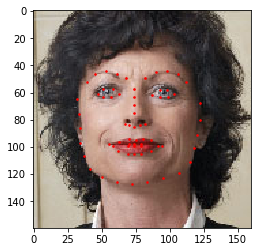

In [6]:
# x, y, s in scatter() is the size of the marker,marker = '.', red color
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:,0], landmarks[:,1], s=10, marker = '.', c='r')

show_landmarks(io.imread(os.path.join('datasets/faces/',img_name)), landmarks)

### Dataset class

In [7]:
# Creating a dataset from the given csv file and images
# Here, we are overriding the methods __len__ and __getitem__
class FaceLandmarksdataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].values
        landmarks = landmarks.astype('float').reshape(-1,2)
        sample = {'image': image, 'landmarks': landmarks}
        # Implementation of the transform classes are below
        if self.transform:
            sample = self.transform(sample)
        return sample

0 (324, 215, 3) (68, 2)
1 (500, 333, 3) (68, 2)
2 (250, 258, 3) (68, 2)
3 (434, 290, 3) (68, 2)
4 (828, 630, 3) (68, 2)


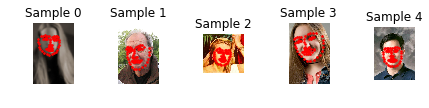

In [8]:
# Instantiating the class -- without transform
face_dataset = FaceLandmarksdataset(csv_file='datasets/faces/face_landmarks.csv',root_dir='datasets/faces/')

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(1,5,i+1)
    # tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area.
    plt.tight_layout()
    ax.set_title('Sample {}'.format(i))
    ax.axis('off')
    # Sample will be passed as a dictionary
    show_landmarks(**sample)
    
    if i==4:
        plt.show()
        break

### Transforms

In [9]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        # When it encounters an assert statement, Python evaluates the accompanying expression, which is hopefully 
        # true. If the expression is false, Python raises an AssertionError exception. If the assertion fails, 
        # Python uses ArgumentExpression as the argument for the AssertionError.
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


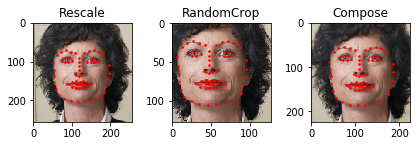

In [10]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()


In [11]:
transformed_dataset = FaceLandmarksdataset(csv_file='./datasets/faces/face_landmarks.csv',
                                           root_dir='./datasets/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224), ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 4:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])
4 torch.Size([3, 224, 224]) torch.Size([68, 2])


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


### Display a batch

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to 

0 torch.Size([5, 3, 224, 224]) torch.Size([5, 68, 2])
1 torch.Size([5, 3, 224, 224]) torch.Size([5, 68, 2])
2 torch.Size([5, 3, 224, 224]) torch.Size([5, 68, 2])
3 torch.Size([5, 3, 224, 224]) torch.Size([5, 68, 2])
4 torch.Size([5, 3, 224, 224]) torch.Size([5, 68, 2])
torch.Size([3, 228, 1132])


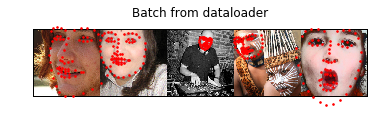

In [13]:
dataloader = DataLoader(transformed_dataset, batch_size=5,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(grid.shape)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        # i * im_size to shift the points across the grid, else they will accumulated on the first image
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 4:
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break